In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime
import scipy.optimize as opt

from pandas_datareader import data, wb
from __future__ import division

import arch

plt.style.use('ggplot')
%matplotlib inline

Download daily prices of the S&P500 index, GE and IBM from finance.yahoo.com starting in 1/1/1970.

In [2]:
px_df = pd.read_csv('./yahoo_data.csv')
px_df.head()

,Date,GE,IBM,^GSPC
0,1970-01-02,0.176514,5.444441,93.000000
1,1970-01-05,0.175650,5.496684,93.459999
2,1970-01-06,0.170467,5.500415,92.820000
3,1970-01-07,0.171330,5.504147,92.629997
4,1970-01-08,0.172770,5.515342,92.680000


In [3]:
class yahoo_finance:
    
    def __init__(self, raw_data, t_idx):
        
        self.px = pd.Series(raw_data.values, index=pd.DatetimeIndex(t_idx))
        self.rets = np.log(self.px).diff().dropna() * 100
        self.m_vol = np.sqrt(self.rets.apply(lambda r: r*r).groupby(pd.TimeGrouper(freq='MS')).sum())
        self.m_ret = self.rets.groupby(pd.TimeGrouper(freq='MS')).sum()
    
    def display(self):
        
        return pd.concat([self.px, self.rets], keys=['Adj Close', 'Return'], axis=1)

s_date = datetime.datetime(1970, 1, 1)

for t in yahoo_ticker.keys():
    vars()[t + '_data'] = data.DataReader(yahoo_ticker[t], 'yahoo', start=s_date)

In [4]:
yahoo_ticker = {
    'GE': 'GE',
    'IBM': 'IBM',
    'SPX': '^GSPC'
}

for t in yahoo_ticker.keys():
    vars()[t + '_df'] = yahoo_finance(px_df[yahoo_ticker[t]], px_df['Date'])

In [5]:
def LogLikelihood(r, param, GJR=True):
    
    # get parameters and set legal range
    mu = param[0]
    
    if GJR:
        w, alpha, beta, phi = (p for p in param[1:])
    else:
        w, alpha, beta = (p for p in param[1:])
    
    # initialize
    T = r.shape[0]
    eps = r - mu
    
    v = np.zeros(T + 1)
    v[0] = np.mean(r * r)
    
    if GJR:
        for i in range(T):
            v[i + 1] = w + beta * v[i] + (alpha + phi if eps[i] < 0 else alpha) * eps[i] * eps[i]
    else:
        for i in range(T):
            v[i + 1] = w + beta * v[i] + alpha * eps[i] * eps[i]

    e = eps / np.sqrt(v[:-1]) 
    sse = e.T.dot(e)
    
    return -0.5 * float(T * np.log(2 * np.pi) + np.sum(np.log(v[:-1])) + sse)

In [6]:
def output_res(p, GJR=True, tick='NONE'):
    
    print '*****', tick, '*****'
    print 'MEAN MODEL'
    print '\tmu = %.4f' %(p[0])
    print 'VOL MODEL'
    if GJR:
        print '\tomega = %.4f \n \talpha = %.4f \n \tbeta = %.4f \n \tphi = %.4f' %(p[1], p[2], p[3], p[4])
    else:
        print '\tomega = %.4f \n \talpha = %.4f \n \tbeta = %.4f' %(p[1], p[2], p[3])

# GARCH(1,1) - constant mean mode

In [7]:
param = np.random.uniform(0, 1, 4)
GARCH_min_object = lambda p: - LogLikelihood(SPX_df.m_ret, p, False)

G11_res = opt.minimize(GARCH_min_object, param, method='nelder-mead',options={'xtol': 1e-8, 'disp': True})
output_res(G11_res.x, False)

/Users/jenchieh/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in sqrt
/Users/jenchieh/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in log


Optimization terminated successfully.
         Current function value: 1627.249798
         Iterations: 225
         Function evaluations: 412
***** NONE *****
MEAN MODEL
	mu = 0.6434
VOL MODEL
	omega = 0.7926 
 	alpha = 0.1230 
 	beta = 0.8431


In [8]:
y = SPX_df.m_ret
mod_G11 = arch.arch_model(y, vol='GARCH', p=1,q=1)
pkg_G11_res = mod_G11.fit()
print(pkg_G11_res.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1628.52151551
Iteration:      2,   Func. Count:     16,   Neg. LLF: 1627.31390509
Iteration:      3,   Func. Count:     24,   Neg. LLF: 1626.97718964
Iteration:      4,   Func. Count:     32,   Neg. LLF: 1626.90395866
Iteration:      5,   Func. Count:     40,   Neg. LLF: 1626.90119341
Iteration:      6,   Func. Count:     47,   Neg. LLF: 1626.83029101
Iteration:      7,   Func. Count:     53,   Neg. LLF: 1626.8208196
Iteration:      8,   Func. Count:     59,   Neg. LLF: 1626.82056116
Iteration:      9,   Func. Count:     65,   Neg. LLF: 1626.82051692
Iteration:     10,   Func. Count:     71,   Neg. LLF: 1626.82051379
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1626.82051379
            Iterations: 10
            Function evaluations: 71
            Gradient evaluations: 10
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   Non

# GJR-GARCH(1,1) - constant mean mode

In [9]:
Vol_Est = {}

In [10]:
#SPX

y = SPX_df.m_ret
t = 'SPX'

param = np.random.uniform(0, 1, 5)
GJR_min_object = lambda p: - LogLikelihood(y, p)

GJR11_res = opt.minimize(GJR_min_object, param, method='nelder-mead',options={'xtol': 1e-8, 'disp': True})
output_res(GJR11_res.x, tick=t)
Vol_Est[t] = GJR11_res.x

mod_GJR11 = arch.arch_model(y=y, vol='GARCH', p=1, o=1, q=1)
pkg_GJR11_res = mod_GJR11.fit()
pkg_GJR11_res.summary()

/Users/jenchieh/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in sqrt
/Users/jenchieh/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in log


Optimization terminated successfully.
         Current function value: 1624.782006
         Iterations: 454
         Function evaluations: 777
***** SPX *****
MEAN MODEL
	mu = 0.5564
VOL MODEL
	omega = 1.2407 
 	alpha = 0.0546 
 	beta = 0.8261 
 	phi = 0.1099
Iteration:      1,   Func. Count:      7,   Neg. LLF: 1625.03571925
Iteration:      2,   Func. Count:     16,   Neg. LLF: 1624.84040732
Iteration:      3,   Func. Count:     25,   Neg. LLF: 1624.71403758
Iteration:      4,   Func. Count:     34,   Neg. LLF: 1624.68131665
Iteration:      5,   Func. Count:     42,   Neg. LLF: 1624.58252667
Iteration:      6,   Func. Count:     50,   Neg. LLF: 1624.5297289
Iteration:      7,   Func. Count:     58,   Neg. LLF: 1624.47678149
Iteration:      8,   Func. Count:     66,   Neg. LLF: 1624.43375528
Iteration:      9,   Func. Count:     75,   Neg. LLF: 1624.42495536
Iteration:     10,   Func. Count:     83,   Neg. LLF: 1624.4040733
Iteration:     11,   Func. Count:     90,   Neg. LLF: 1624.401

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Constant Mean - GJR-GARCH Model Results                    
==============================================================================
Dep. Variable:                   None   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -1624.40
Distribution:                  Normal   AIC:                           3258.80
Method:            Maximum Likelihood   BIC:                           3280.52
                                        No. Observations:                  569
Date:                Thu, May 18 2017   Df Residuals:                      564
Time:                        13:13:41   Df Model:                            5
                                  Mean Model                                  
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
mu             0.5597      0.166      3.379  7.284e-04       [  0.235,  0.884]
                               Volatility Model                               
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
omega          1.2540      1.907      0.657      0.511       [ -2.485,  4.993]
alpha[1]       0.0548      0.107      0.511      0.609       [ -0.155,  0.265]
gamma[1]       0.1097      0.161      0.683      0.495       [ -0.205,  0.424]
beta[1]        0.8251  9.657e-02      8.545  1.288e-17       [  0.636,  1.014]
==============================================================================

Covariance estimator: robust
"""

In [11]:
#GE

y = GE_df.m_ret
t = 'GE'

param = np.random.uniform(0, 1, 5)
GJR_min_object = lambda p: - LogLikelihood(y, p)

GJR11_res = opt.minimize(GJR_min_object, param, method='nelder-mead',options={'xtol': 1e-8, 'disp': True})
output_res(GJR11_res.x, tick=t)
Vol_Est[t] = GJR11_res.x

mod_GJR11 = arch.arch_model(y=y, vol='GARCH', p=1, o=1, q=1)
pkg_GJR11_res = mod_GJR11.fit()
pkg_GJR11_res.summary()

/Users/jenchieh/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in sqrt
/Users/jenchieh/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in log


Optimization terminated successfully.
         Current function value: 1862.124205
         Iterations: 499
         Function evaluations: 843
***** GE *****
MEAN MODEL
	mu = 0.9392
VOL MODEL
	omega = 3.1897 
 	alpha = 0.0603 
 	beta = 0.8175 
 	phi = 0.1031
Iteration:      1,   Func. Count:      7,   Neg. LLF: 1863.24076512
Iteration:      2,   Func. Count:     16,   Neg. LLF: 1862.84400569
Iteration:      3,   Func. Count:     25,   Neg. LLF: 1862.49549047
Iteration:      4,   Func. Count:     33,   Neg. LLF: 1862.40275967
Iteration:      5,   Func. Count:     41,   Neg. LLF: 1862.28961606
Iteration:      6,   Func. Count:     49,   Neg. LLF: 1862.11479407
Iteration:      7,   Func. Count:     57,   Neg. LLF: 1862.08982641
Iteration:      8,   Func. Count:     65,   Neg. LLF: 1862.06100405
Iteration:      9,   Func. Count:     72,   Neg. LLF: 1862.05933994
Iteration:     10,   Func. Count:     79,   Neg. LLF: 1862.0592528
Iteration:     11,   Func. Count:     86,   Neg. LLF: 1862.059

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Constant Mean - GJR-GARCH Model Results                    
==============================================================================
Dep. Variable:                   None   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -1862.06
Distribution:                  Normal   AIC:                           3734.12
Method:            Maximum Likelihood   BIC:                           3755.84
                                        No. Observations:                  569
Date:                Thu, May 18 2017   Df Residuals:                      564
Time:                        13:14:02   Df Model:                            5
                                  Mean Model                                  
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
mu             0.9386      0.258      3.635  2.776e-04       [  0.433,  1.445]
                               Volatility Model                               
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
omega          3.2147      1.718      1.871  6.138e-02       [ -0.153,  6.583]
alpha[1]       0.0599  3.884e-02      1.542      0.123    [-1.624e-02,  0.136]
gamma[1]       0.1038  7.148e-02      1.452      0.147    [-3.632e-02,  0.244]
beta[1]        0.8171  4.595e-02     17.782  9.702e-71       [  0.727,  0.907]
==============================================================================

Covariance estimator: robust
"""

In [12]:
#IBM

y = IBM_df.m_ret
t = 'IBM'

param = np.random.uniform(0, 1, 5)
GJR_min_object = lambda p: - LogLikelihood(y, p)

GJR11_res = opt.minimize(GJR_min_object, param, method='nelder-mead',options={'xtol': 1e-8, 'disp': True})
output_res(GJR11_res.x, tick=t)
Vol_Est[t] = GJR11_res.x

mod_GJR11 = arch.arch_model(y=y, vol='GARCH', p=1, o=1, q=1)
pkg_GJR11_res = mod_GJR11.fit()
pkg_GJR11_res.summary()

Optimization terminated successfully.
         Current function value: 1888.054468
         Iterations: 482
         Function evaluations: 839
***** IBM *****
MEAN MODEL
	mu = 0.5888
VOL MODEL
	omega = 4.1427 
 	alpha = 0.0649 
 	beta = 0.7980 
 	phi = 0.1066
Iteration:      1,   Func. Count:      7,   Neg. LLF: 1888.62430986
Iteration:      2,   Func. Count:     16,   Neg. LLF: 1888.36152393
Iteration:      3,   Func. Count:     25,   Neg. LLF: 1888.25662739
Iteration:      4,   Func. Count:     34,   Neg. LLF: 1888.23111245
Iteration:      5,   Func. Count:     43,   Neg. LLF: 1888.23052729
Iteration:      6,   Func. Count:     50,   Neg. LLF: 1888.16271325
Iteration:      7,   Func. Count:     57,   Neg. LLF: 1888.14618833
Iteration:      8,   Func. Count:     64,   Neg. LLF: 1888.14585512
Iteration:      9,   Func. Count:     71,   Neg. LLF: 1888.14584959
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1888.14584959
            Iterations:

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Constant Mean - GJR-GARCH Model Results                    
==============================================================================
Dep. Variable:                   None   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -1888.15
Distribution:                  Normal   AIC:                           3786.29
Method:            Maximum Likelihood   BIC:                           3808.01
                                        No. Observations:                  569
Date:                Thu, May 18 2017   Df Residuals:                      564
Time:                        13:14:24   Df Model:                            5
                                  Mean Model                                  
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
mu             0.5827      0.258      2.258  2.392e-02     [7.702e-02,  1.088]
                               Volatility Model                               
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
omega          4.1312      2.638      1.566      0.117       [ -1.039,  9.302]
alpha[1]       0.0644  2.718e-02      2.369  1.784e-02     [1.112e-02,  0.118]
gamma[1]       0.1071  9.903e-02      1.082      0.279    [-8.699e-02,  0.301]
beta[1]        0.7988  8.426e-02      9.480  2.541e-21       [  0.634,  0.964]
==============================================================================

Covariance estimator: robust
"""

In [13]:
def GARCH_Est_Vol(r, param, GJR=True):
    
    # get parameters and set legal range
    mu = param[0]
    
    if GJR:
        w, alpha, beta, phi = (p for p in param[1:])
    else:
        w, alpha, beta = (p for p in param[1:])
    
    # initialize
    T = r.shape[0]
    eps = r - mu
    
    v = np.zeros(T + 1)
    v[0] = np.mean(r * r)
    
    if GJR:
        for i in range(T):
            v[i + 1] = w + beta * v[i] + (alpha + phi if eps[i] < 0 else alpha) * eps[i] * eps[i]
    else:
        for i in range(T):
            v[i + 1] = w + beta * v[i] + alpha * eps[i] * eps[i]
    
    return np.sqrt(v[1:-1])
    #return np.sqrt(v[1:])


def RMSE(est, theta):
    
    return np.sqrt(np.mean((est - theta)**2))

RMSE_SPX 2.23061893153
RMSE_IBM 2.96517340519
RMSE_GE 3.13262996666


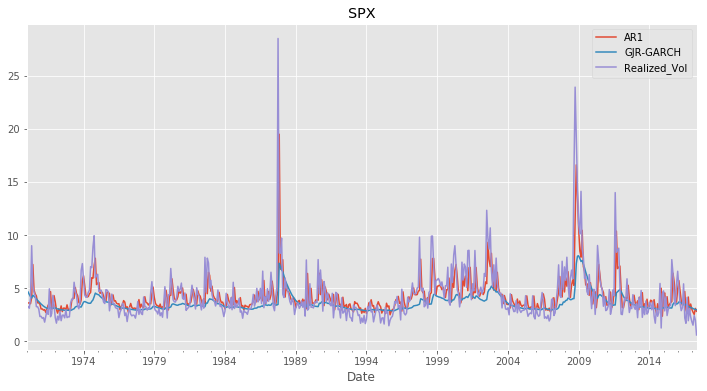

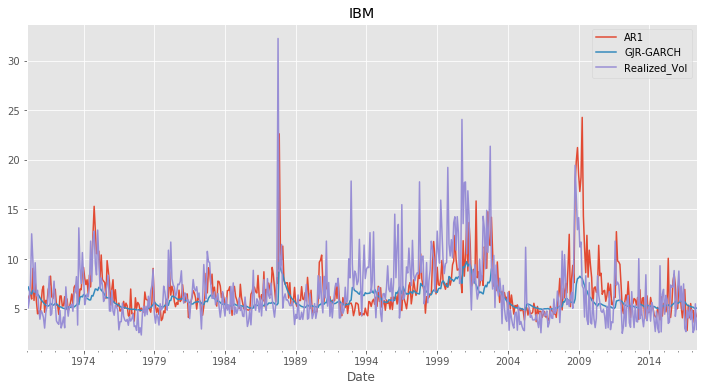

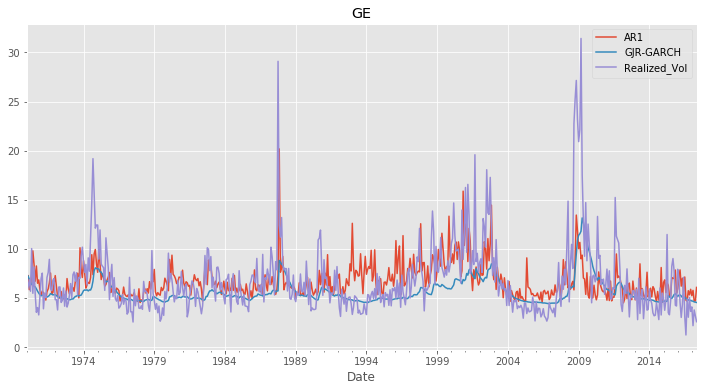

In [14]:
m_vol_df = {}

ar1_forcast = pd.read_csv('~/Downloads/AR1_forecast.csv',index_col=0)
ar1_forcast.columns = ['SPX', 'IBM', 'GE']

for t in ['SPX', 'IBM', 'GE']:

    vol = GARCH_Est_Vol(vars()[t + '_df'].m_vol, Vol_Est[t])

    m_vol_df[t] = pd.DataFrame({
        'Realized_Vol': vars()[t + '_df'].m_vol,
        'GJR-GARCH': np.r_[np.nan, vol],
        'AR1': np.r_[np.nan, ar1_forcast[t].values]
    })
    
    m_vol_df[t].plot(figsize=(12,6), title=t)
    print 'RMSE_%s'%(t), RMSE(vol, vars()[t + '_df'].m_vol.iloc[1:])

In [15]:
pd.DataFrame(Vol_Est, index=['omega', 'mu', 'alpha', 'beta', 'phi'])

,GE,IBM,SPX
omega,0.939199,0.588842,0.556437
mu,3.189741,4.142740,1.240738
alpha,0.060255,0.064916,0.054614
beta,0.817496,0.798015,0.826077
phi,0.103083,0.106554,0.109895


In [16]:
GJR11_forcast = pd.concat([m_vol_df[t]['GJR-GARCH'] for t in ['SPX', 'GE', 'IBM']],axis=1)
GJR11_forcast.columns = ['SPX', 'GE', 'IBM']
GJR11_forcast.to_csv('GJR11_forcast.csv')
GJR11_forcast.head()

,SPX,GE,IBM
Date,,,
1970-01-01,NaN,NaN,NaN
1970-02-01,4.615109,7.216198,7.205117
1970-03-01,4.385114,6.884247,6.846425
1970-04-01,4.180534,6.636787,6.583269
1970-05-01,4.041825,6.368050,6.481574
